In [131]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import pymannkendall as mk
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils.plotting import plot_series

In [132]:

well_data = pd.read_excel('../data/Data-Wells.xlsx')

well_data.head(10)

,Sample ID,Well Name,Entered,"1,4-Dioxane Results (ppb)",Date Sampled,Time Sampled,Date Received,Date Analyzed,Reporting Limit,Reporting Lab,...,Well Comments,Scr Elev Range,bar color,BegFolder KML,EndFolder KML,BegFolder2KML,EndFolder2KML,Max-to-date.1,MaxToDateFlag,Last Date Rd
0,76970,1021 Westview Way,05/10/19,nd,05/08/19,14:05,NaN,05/15/19,1.0,PLS,...,NaN,NaN,green,<Folder><name>1021 Westview Way</name>,</Folder>,<Folder><name>n/a</name>,NaN,0.001,NaN,2019-05-08 00:00:00
1,76971,1024 Westview Way,05/10/19,nd,05/08/19,14:18,NaN,05/15/19,1.0,PLS,...,NaN,NaN,green,<Folder><name>1024 Westview Way</name>,</Folder>,NaN,NaN,0.001,NaN,2019-05-08 00:00:00
2,76969,1049 Westview Way,05/10/19,nd,05/08/19,14:43,NaN,05/14/19,1.0,PLS,...,NaN,NaN,green,<Folder><name>1049 Westview Way</name>,</Folder>,NaN,</Folder>,0.001,NaN,2019-05-08 00:00:00
3,3525,105 Myrtle,NaN,nd,03/27/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,<Folder><name>105 Myrtle</name>,NaN,<Folder><name>800-820</name>,NaN,0.001,NaN,2019-04-15 00:00:00
4,3714,105 Myrtle,NaN,nd,05/28/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
5,4013,105 Myrtle,NaN,nd,08/19/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
6,4337,105 Myrtle,NaN,nd,11/16/99,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
7,4671,105 Myrtle,NaN,nd,02/21/00,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
8,5428,105 Myrtle,NaN,nd,08/21/00,NaN,NaN,NaN,1.0,MEG,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00
9,74144,105 Myrtle,06/19/14,nd,06/18/14,12:15,NaN,06/26/14,1.0,PLS,...,Replacement water supply well.,800-820,green,NaN,NaN,NaN,NaN,0.001,NaN,2019-04-15 00:00:00


## clean

In [134]:

rm_nd = well_data.loc[well_data['1,4-Dioxane Results (ppb)'] != 'nd'].copy()

rm_capital_nd = rm_nd.loc[rm_nd['1,4-Dioxane Results (ppb)'] != 'ND'].copy()

rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace(',', ''))

rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace('<', ''))

rm_invalid_lon_lat = rm_capital_nd.loc[rm_capital_nd['LONG']!= '0' & rm_capital_nd['LAT'] != '0'].copy()

res = rm_invalid_lon_lat
res.loc[:, 'ds']= pd.to_datetime(res['Date Sampled'])
res.loc[:, 'dioxane_results']= pd.to_numeric(res['1,4-Dioxane Results (ppb)'])
res.head(5)

,Sample ID,Well Name,Entered,"1,4-Dioxane Results (ppb)",Date Sampled,Time Sampled,Date Received,Date Analyzed,Reporting Limit,Reporting Lab,...,bar color,BegFolder KML,EndFolder KML,BegFolder2KML,EndFolder2KML,Max-to-date.1,MaxToDateFlag,Last Date Rd,ds,dioxane_results
16,57,110 Parkland Plaza,NaN,17,08/22/86,NaN,NaN,NaN,1.0,NaN,...,orange,<Folder><name>110 Parkland Plaza</name>,NaN,<Folder><name>840-860</name>,NaN,17.0,MaxToDate,2019-09-12 00:00:00,1986-08-22,17.0
17,58,110 Parkland Plaza,NaN,17,09/19/86,NaN,NaN,NaN,1.0,NaN,...,orange,NaN,NaN,NaN,NaN,17.0,MaxToDate,2019-09-12 00:00:00,1986-09-19,17.0
18,61,110 Parkland Plaza,NaN,12,10/10/86,NaN,NaN,NaN,1.0,NaN,...,orange,NaN,NaN,NaN,NaN,17.0,NaN,2019-09-12 00:00:00,1986-10-10,12.0
19,62,110 Parkland Plaza,NaN,1,10/10/86,NaN,NaN,NaN,1.0,NaN,...,yellow,NaN,NaN,NaN,NaN,17.0,NaN,2019-09-12 00:00:00,1986-10-10,1.0
20,187,110 Parkland Plaza,NaN,7,11/09/87,NaN,NaN,NaN,1.0,NaN,...,orange,NaN,NaN,NaN,NaN,17.0,NaN,2019-09-12 00:00:00,1987-11-09,7.0


In [135]:
# iterating the columns
for col in res.columns:
    print(col)

Sample ID
Well Name
Entered
1,4-Dioxane Results (ppb)
Date Sampled
Time Sampled
Date Received
Date Analyzed
Reporting Limit
Reporting Lab
Static Reading
Static Time
Static Only?
Qualifier(s)
Comments
Bromate Results (ppb)
Date Bromate Analyzed
Bromate Reporting Limit
Bromate Reporting Lab
Bromide Results (ppb)
Date Bromide Analyzed
Bromide Reporting Limit
Bromide Reporting Lab
Completed Sample?
DateRead#
dioxane holding time
count days>14
year sampled
month sampled
yyyy-mm-dd
next date
ppb as #
adj ppb as text
WellName/Year
Max/Yr
Max-to-date
MaxFlag/Yr
MaxPPB
MaxFlag
Date of Max
Aquifer
AQUIFER2
Map Location
X CORD
Y CORD
LONG
LAT
Date Installed
Well Driller (if known)
Well Types
Sampling Interval
Static Interval
Boring Depth  (Feet bgl)
Ground Elevation
TOC Elevation AMSL (Feet)
Depth from TOC to bottom of screen (Feet)
TOC above Ground
 Approx  Elev = Ground - Bottom Scr
Official Elev = TOC - TOC to Scr Bot elev
Genl Bot Scr Elev
Top of Screen 1
Bottom of Screen 1
Screen Length (Fee

In [136]:
di_time = res.iloc[:, lambda df: df.columns.str.contains('Well Name|ds|dioxane_results|LONG|LAT',
                                              case=False)].copy()
di_time.rename(columns = {'dioxane_results':'y'}, inplace = True)

,Well Name,LONG,LAT,ds,y
16,110 Parkland Plaza,-83.814302,42.283187,1986-08-22,17.0
17,110 Parkland Plaza,-83.814302,42.283187,1986-09-19,17.0
18,110 Parkland Plaza,-83.814302,42.283187,1986-10-10,12.0
19,110 Parkland Plaza,-83.814302,42.283187,1986-10-10,1.0
20,110 Parkland Plaza,-83.814302,42.283187,1987-11-09,7.0
21,110 Parkland Plaza,-83.814302,42.283187,1987-11-09,18.0
22,110 Parkland Plaza,-83.814302,42.283187,1988-04-18,13.0
23,110 Parkland Plaza,-83.814302,42.283187,1988-12-09,14.0
24,110 Parkland Plaza,-83.814302,42.283187,1989-07-19,11.0
25,110 Parkland Plaza,-83.814302,42.283187,1990-01-30,12.0


## prepare data for training

In [ ]:
min_date = min(di_time['ds'])
min_date

In [140]:

di_time['days'] = di_time['ds'].map(lambda x: (x-min_date).days)
di_time.head(10)

,Well Name,LONG,LAT,ds,y,days
16,110 Parkland Plaza,-83.814302,42.283187,1986-08-22,17.0,210
17,110 Parkland Plaza,-83.814302,42.283187,1986-09-19,17.0,238
18,110 Parkland Plaza,-83.814302,42.283187,1986-10-10,12.0,259
19,110 Parkland Plaza,-83.814302,42.283187,1986-10-10,1.0,259
20,110 Parkland Plaza,-83.814302,42.283187,1987-11-09,7.0,654
21,110 Parkland Plaza,-83.814302,42.283187,1987-11-09,18.0,654
22,110 Parkland Plaza,-83.814302,42.283187,1988-04-18,13.0,815
23,110 Parkland Plaza,-83.814302,42.283187,1988-12-09,14.0,1050
24,110 Parkland Plaza,-83.814302,42.283187,1989-07-19,11.0,1272
25,110 Parkland Plaza,-83.814302,42.283187,1990-01-30,12.0,1467


In [141]:
X = di_time.iloc[:, [1, 2, 5]].values
Y = di_time.iloc[:, 4].values
X

array([[ -83.81430215,   42.28318681,  210.        ],
       [ -83.81430215,   42.28318681,  238.        ],
       [ -83.81430215,   42.28318681,  259.        ],
       ...,
       [   0.        ,    0.        , 7458.        ],
       [   0.        ,    0.        , 7452.        ],
       [   0.        ,    0.        , 7458.        ]])

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=5, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(2)

Mean Absolute Error: 395.78967570333225
Mean Squared Error: 10830839.85023608
Root Mean Squared Error: 3291.0241339492
2


Timestamp('1986-01-24 00:00:00')

In [138]:
X_test

,Well Name,LONG,LAT,ds,y,days
16,110 Parkland Plaza,-83.814302,42.283187,1986-08-22,17.0,210
17,110 Parkland Plaza,-83.814302,42.283187,1986-09-19,17.0,238
18,110 Parkland Plaza,-83.814302,42.283187,1986-10-10,12.0,259
19,110 Parkland Plaza,-83.814302,42.283187,1986-10-10,1.0,259
20,110 Parkland Plaza,-83.814302,42.283187,1987-11-09,7.0,654
21,110 Parkland Plaza,-83.814302,42.283187,1987-11-09,18.0,654
22,110 Parkland Plaza,-83.814302,42.283187,1988-04-18,13.0,815
23,110 Parkland Plaza,-83.814302,42.283187,1988-12-09,14.0,1050
24,110 Parkland Plaza,-83.814302,42.283187,1989-07-19,11.0,1272
25,110 Parkland Plaza,-83.814302,42.283187,1990-01-30,12.0,1467


-83.8143021529606
<class 'pandas.core.series.Series'>
[[-83.8143021529606, 42.2831868070381, 7787], [-83.8143021529606, 42.2831868070381, 7930], [-83.8143021529606, 42.2831868070381, 8222], [-83.8143021529606, 42.2831868070381, 8599], [-83.8143021529606, 42.2831868070381, 8952], [-83.8143021529606, 42.2831868070381, 9367], [-83.8143021529606, 42.2831868070381, 9699], [-83.8143021529606, 42.2831868070381, 10037], [-83.8143021529606, 42.2831868070381, 10416], [-83.8143021529606, 42.2831868070381, 10779], [-83.8143021529606, 42.2831868070381, 11184], [-83.8143021529606, 42.2831868070381, 11506], [-83.8143021529606, 42.2831868070381, 11890], [-83.8143021529606, 42.2831868070381, 12284]]
<class 'pandas.core.indexes.period.PeriodIndex'>
<class 'pandas.core.indexes.period.PeriodIndex'>
[5.6  6.   5.4  4.   4.8  4.6  3.4  5.   3.8  2.8  4.64 2.68 2.06 1.6 ]
2007-05-21    5.60
2007-10-11    6.00
2008-07-29    5.40
2009-08-10    4.00
2010-07-29    4.80
2011-09-17    4.60
2012-08-14    3.40
2013-

ValueError: array length 22 does not match index length 21

<Figure size 360x7200 with 0 Axes>

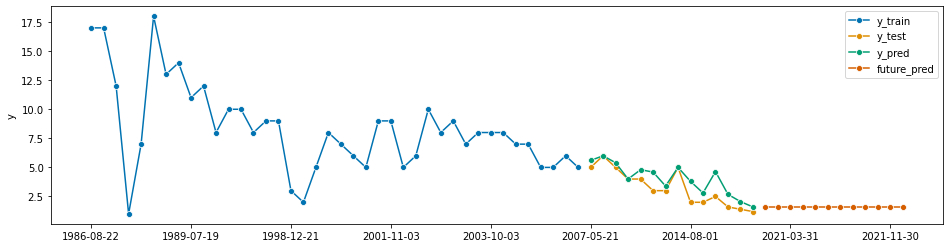

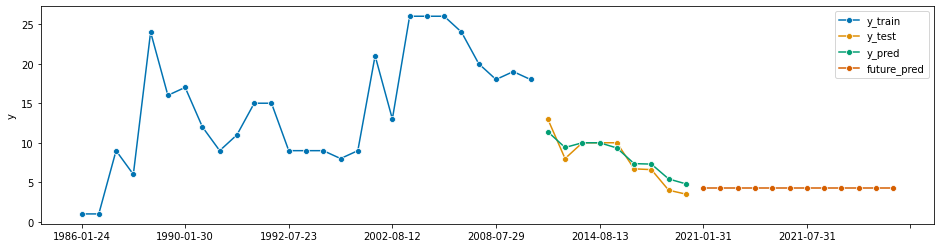

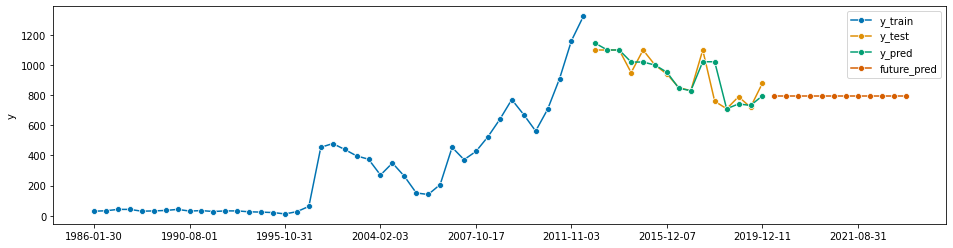

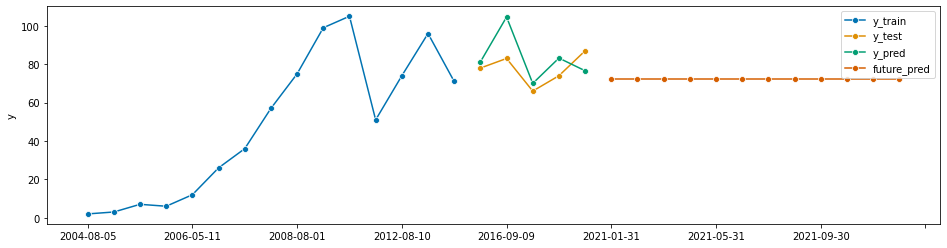

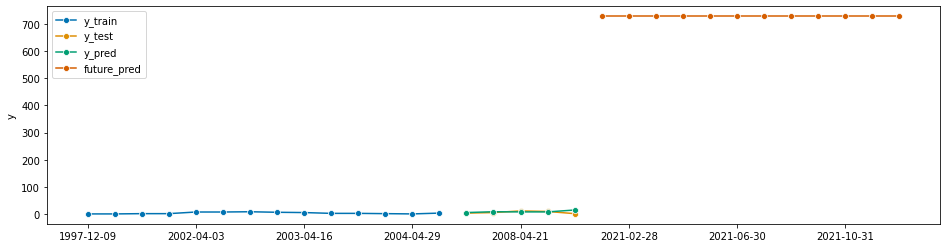

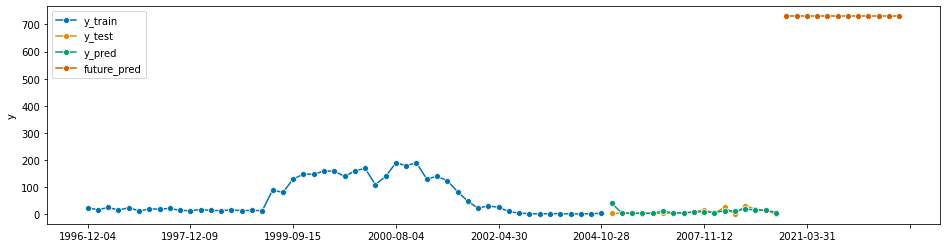

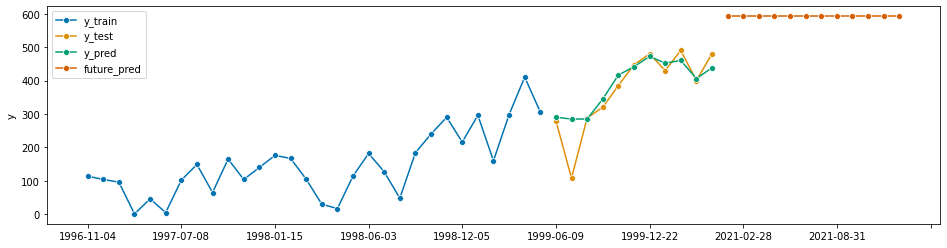

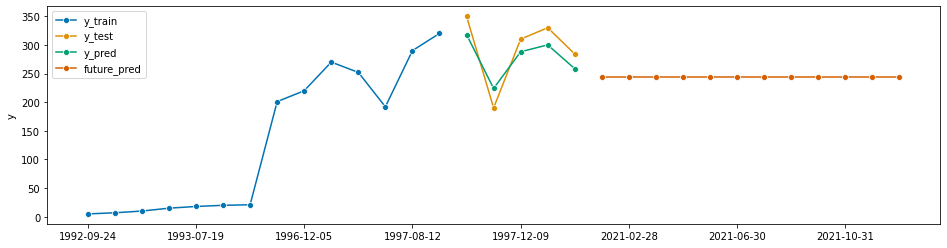

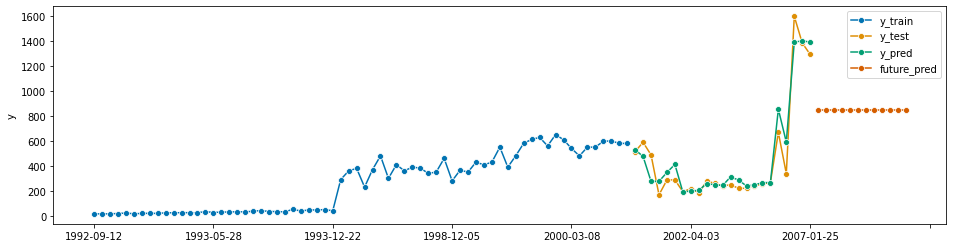

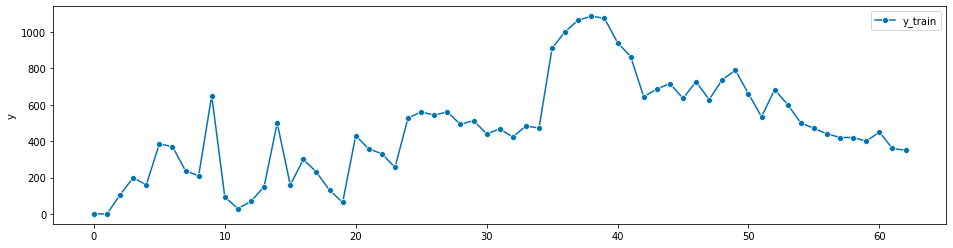

In [144]:

grouped = di_time.groupby('Well Name')
count = 1
n_rows = 20
n_cols = 1
fig = plt.figure(figsize=(5*n_cols, 5*n_rows))

mk_res = []

for name, group in grouped:
    if count > n_rows:
        break
    if len(group) < 10:
        continue

    print(group['LONG'].tolist()[0])
    test = group.set_index('ds')['y'].rename_axis(None)
    test.index = test.index.to_period("D")
    y_train, y_test = temporal_train_test_split(test)
    print(type(y_test))

    x_test = []
    for i in y_test.index:
        days_i = i.to_timestamp() - min_date
        x_test.append([group['LONG'].tolist()[0], group['LAT'].tolist()[0], days_i.days])
    print(x_test)
    x_test_np = np.array(x_test)
    print(type(y_test.index))

    future_from_now = pd.date_range("2021-01-01", periods=12, freq="M").to_period("D")

    print(type(future_from_now))
    future_from_now_predict = []
    for i in future_from_now:
        days_i = i.to_timestamp() - min_date
        future_from_now_predict.append([group['LONG'].tolist()[0], group['LAT'].tolist()[0], days_i.days])
    future_from_now_predict_np = np.array(future_from_now_predict)

    y_pred_rf = regressor.predict(x_test_np)
    y_pred_from_now_rf = regressor.predict(future_from_now_predict_np)
    print(y_pred_rf)
    y_pred_rf_series = pd.Series(y_pred_rf, index=y_test.index)
    y_pred_from_now_rf_series = pd.Series(y_pred_from_now_rf, index=future_from_now)
    print(y_pred_rf_series)
    plot_series(y_train, y_test, y_pred_rf_series, y_pred_from_now_rf_series, labels=["y_train", "y_test", "y_pred", "future_pred"])

    count+=1